In [7]:
'''
Mejores Resultados:
1. poner softmax en las acc y loss function
2. usar cross entropy loss


3. Revisar como funciona binary_cross_entropy_with_logits

'''

'\nMejores Resultados:\n1. poner softmax en las acc y loss function\n2. usar cross entropy loss\n\n\n3. Revisar como funciona binary_cross_entropy_with_logits\n\n'

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Data Augmentation](#aug)
- [5 - Metadata](#meta)
- [6 - Carga de imágenes y metadata](#carga)
- [7 - Creación de DataBlock](#db)
- [8 - Función de Accuracy: ATSIA_ACC](#acc_atsia)
- [9 - Función de Pérdida: Binary Cross-Entropy with Logits Loss](#loss_fun)
- [10 - Modelo](#model)
- [11 - Métricas](#metrics)
- [12 - Resutados](#results)
- [13 - Widget Prueba](#widget)

<a name='lib'></a>
## Librerías

In [8]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from utils_ATSIA import *

import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [9]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]
caracteristicas = {"AmpollaRectal" :["GG", "N"], #"Gregarinas Gametocistos, Nemátodos"
                   "Branquias" : ["S", "M", "N", "P", "AF"],# "Suciedad, Melanización, Necrosis, Protozoarios y Algas Filamentosas"
                   "Hepatopancreas" : ["DC", "DT", "L", "M", "N"], #"Deformidad Celular, Desprendimiento Tubular, Lípidos, Melanización y Necrosis"
                   "Intestino" : ["GT", "GG", "N", "A", "RC"], #"Gregarinas Trofozoito, Gregarina Gametocistos, Nemátodos, Algas y Restos de Crustaceos"
                   "Uropodo" : ["Prem", "Muda", "Post", "Inte"]}

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 26, "Intestino" : 27, "Uropodo" :4}

In [10]:
main_path = Path(os.getcwd()) #Cuando estemos en local
Path.BASE_PATH = main_path
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos: 
    if not os.path.exists(Path(os.path.join("data", organo))):
        os.mkdir(Path(os.path.join("data", organo)))
    if not os.path.exists(Path(os.path.join("img", organo))):
        os.mkdir(Path(os.path.join("img", organo)))
    if not os.path.exists(Path(os.path.join("metadata", organo))):
        os.mkdir(Path(os.path.join("metadata", organo)))

for organo in organos:
    path["data"][organo] = Path(os.path.join("data", organo, f"X_{organo}.npy"))
    path["img"][organo] = Path(os.path.join("img", organo))
    path["metadata"][organo] = Path(os.path.join("metadata", organo, f"metadata_{organo}.csv"))

<a name='eda'></a>
## Análisis Exploratorio de Datos (EDA)

In [11]:
count = get_img_count(organos, organo_len, caracteristicas, grados, path)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 205.87it/s]


No hay imágenes en la carpeta img/AmpollaRectal
No hay imágenes en la carpeta img/Branquias


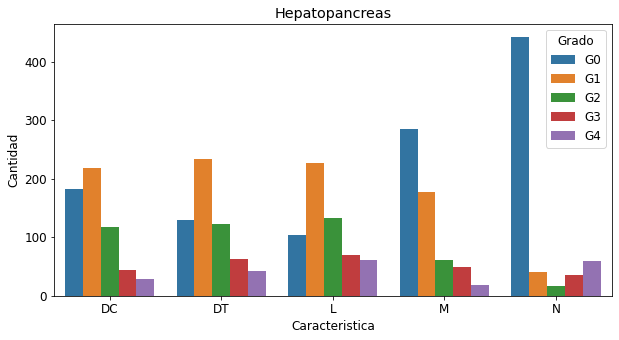

No hay imágenes en la carpeta img/Intestino
No hay imágenes en la carpeta img/Uropodo


In [12]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        hepato=data
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Caracteristica", y = "Cantidad", hue = "Grado")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")

No hay imágenes en la carpeta img/AmpollaRectal
No hay imágenes en la carpeta img/Branquias


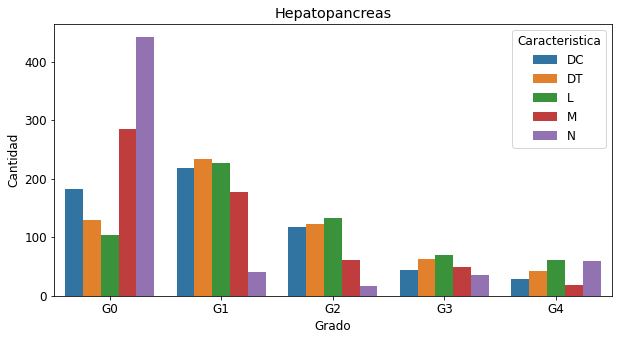

No hay imágenes en la carpeta img/Intestino
No hay imágenes en la carpeta img/Uropodo


In [13]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Grado", y = "Cantidad", hue = "Caracteristica")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")


<a name='model'></a> 
## Class weight for imbalanced datasets

In [14]:
# pos_weight= {}
# weight = {}
# for organo in organos:
#     total_img = len(get_image_files(path["img"][organo]))
#     pos_count = count[count["Organo"] == organo]["Cantidad"]
#     pos_weight[organo] = (total_img - pos_count)/pos_count
#     weight[organo] = (total_img)/pos_count

In [15]:
# pos_weight["Hepatopancreas"].values

In [16]:
# weight["Hepatopancreas"].values

<a name='meta'></a>
## Metada

In [17]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [18]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata

img_name                      labels
0         DT_G3-DC_G0-L_G4-M_G0-N_G0.png  DT_G3 DC_G0 L_G4 M_G0 N_G0
1     DT_G2-DC_G0-L_G2-M_G1-N_G1 (2).png  DT_G2 DC_G0 L_G2 M_G1 N_G1
2     DT_G4-DC_G2-L_G4-M_G3-N_G4 (7).png  DT_G4 DC_G2 L_G4 M_G3 N_G4
3     DT_G1-DC_G4-L_G2-M_G4-N_G1 (2).png  DT_G1 DC_G4 L_G2 M_G4 N_G1
4    DT_G1-DC_G0-L_G1-M_G0-N_G0 (13).png  DT_G1 DC_G0 L_G1 M_G0 N_G0
..                                   ...                         ...
587       DT_G0-DC_G1-L_G3-M_G0-N_G2.png  DT_G0 DC_G1 L_G3 M_G0 N_G2
588   DT_G0-DC_G0-L_G1-M_G0-N_G0 (9).png  DT_G0 DC_G0 L_G1 M_G0 N_G0
589       DT_G2-DC_G1-L_G3-M_G2-N_G3.png  DT_G2 DC_G1 L_G3 M_G2 N_G3
590   DT_G1-DC_G2-L_G1-M_G2-N_G0 (2).png  DT_G1 DC_G2 L_G1 M_G2 N_G0
591       DT_G3-DC_G1-L_G1-M_G1-N_G0.png  DT_G3 DC_G1 L_G1 M_G1 N_G0

[592 rows x 2 columns]

<a name='carga'></a> 
## Carga de imágenes y metadata 

In [19]:
metadata_csv = pd.read_csv(path["metadata"][organo], sep = ",")
metadata_csv.sample(3)

img_name                      labels
499  DT_G2-DC_G1-L_G2-M_G0-N_G1.png  DT_G2 DC_G1 L_G2 M_G0 N_G1
587  DT_G0-DC_G1-L_G3-M_G0-N_G2.png  DT_G0 DC_G1 L_G3 M_G0 N_G2
195  DT_G1-DC_G0-L_G3-M_G0-N_G0.png  DT_G1 DC_G0 L_G3 M_G0 N_G0

<a name='aug'></a> 
## Data Augmentation

In [20]:
img = PILImage(PILImage.create("TEST_IMAGE.png").resize((600,400)))
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

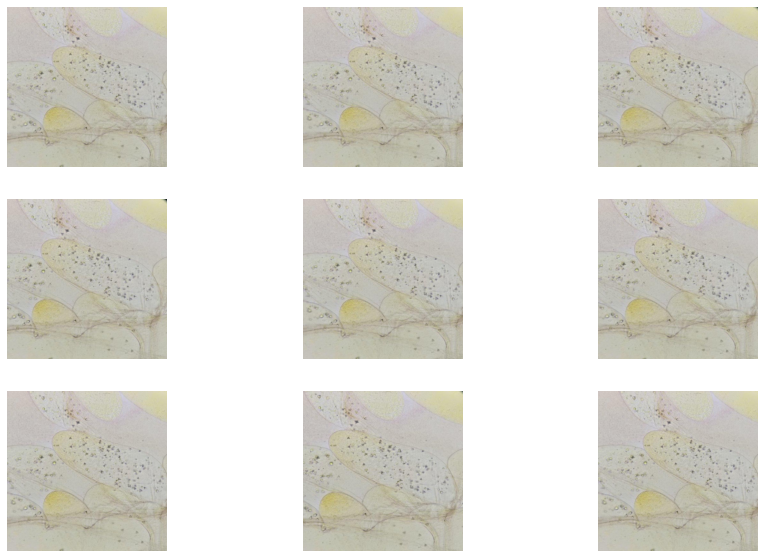

In [21]:
_,axs = plt.subplots(3,3, figsize=(15,10))
for ax in axs.flatten():
    show_image(RandomResizedCrop(500, min_scale = 0.8, max_scale = 1)(img, split_idx=0), ctx=ax)
#     show_image(Resize(500,method='crop', pad_mode='zeros')(img, split_idx=0), ctx=ax)

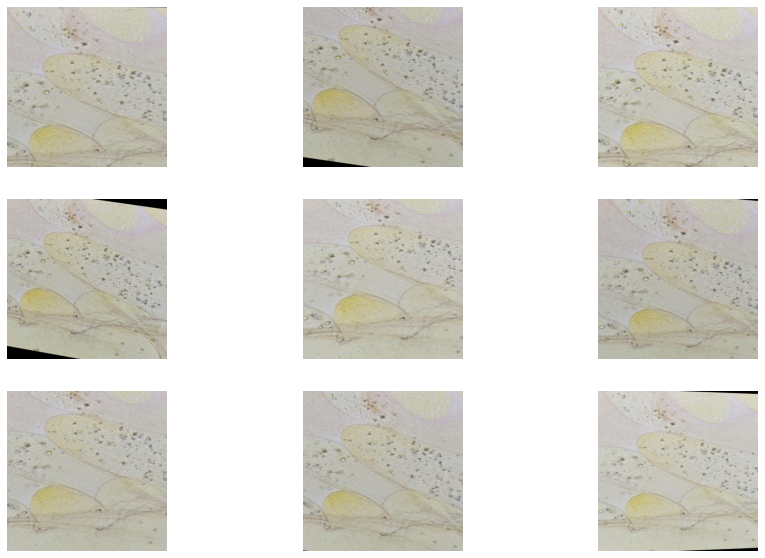

In [22]:
tfms = aug_transforms(mult=1.0, 
                      do_flip=False, 
                      flip_vert=True, 
                      max_rotate=10.0, 
                      min_zoom=1.0, 
                      max_zoom=1.2, 
                      max_lighting=0.1, 
                      max_warp=0.1, 
                      p_affine=0.75, 
                      p_lighting=0.75, 
                      xtra_tfms=None, 
                      mode='bilinear', 
                      pad_mode='zeros', 
                      align_corners=True, 
                      batch=False, 
                      min_scale=0.8)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(3,3, figsize=(15,10))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

<a name='db'></a> 
## Creación de DataBlock

In [35]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(" ")
     
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y, 
                   item_tfms = Resize(500, method='crop', pad_mode='zeros'), # RatioResize(500)
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   #batch_tfms = Normalize.from_stats(*imagenet_stats)
#                  batch_tfms =[*aug_transforms(mult=1.0,
#                                               do_flip=True,
#                                               flip_vert=True,
#                                               max_rotate=10.0, 
#                                               min_zoom=1.0, 
#                                               max_zoom=1.2, 
#                                               max_lighting=0.1, 
#                                               max_warp=0.1, 
#                                               p_affine=0.75, 
#                                               p_lighting=0.75,  
#                                               mode='bilinear', 
#                                               pad_mode='reflection', 
#                                               align_corners=True, 
#                                               batch=False, 
#                                               min_scale=1.0),Normalize.from_stats(*imagenet_stats)]
                   )
dls = dblock.dataloaders(metadata_csv, bs=16)

### Con batchsize = 16

In [36]:
dsets = dblock.datasets(metadata_csv)
dsets.train[0]

(PILImage mode=RGB size=2040x1528,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [37]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#5) ['DC_G1','DT_G1','L_G2','M_G1','N_G0']

In [38]:
print(len(dls.vocab))
labels = dls.vocab
print(labels)

25
['DC_G0', 'DC_G1', 'DC_G2', 'DC_G3', 'DC_G4', 'DT_G0', 'DT_G1', 'DT_G2', 'DT_G3', 'DT_G4', 'L_G0', 'L_G1', 'L_G2', 'L_G3', 'L_G4', 'M_G0', 'M_G1', 'M_G2', 'M_G3', 'M_G4', 'N_G0', 'N_G1', 'N_G2', 'N_G3', 'N_G4']


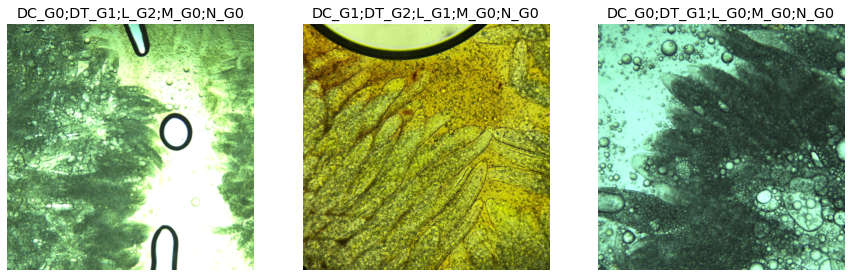

In [39]:
dls.show_batch(nrows=1, ncols=3, figsize=(15,10))

<a name='acc_atsia'></a> 
## Función de Accuracy: ATSIA_ACC

In [40]:
def get_info():
    return organo, caracteristicas, grados

def accuracy_multi_atsia(y_preds, y):
    y_preds = y_preds.sigmoid()    
    
    organo, caracteristicas, grados = get_info()
    columns =[]
    for caracteristica in caracteristicas[organo]:
        columns.append(f"ACC_{caracteristica}")
    #Al final columns vendrá en la forma columns = ["ACC_DC", "ACC_DT", "ACC_L", "ACC_M", "ACC_N"] para Hepatopancreas

    acc = pd.DataFrame(np.zeros((len(y_preds), len(columns))), columns = columns)

    for i in range(0, len(y_preds)):
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                preds = y_preds[i][len(grados)*j : len(grados)*(j+1)]
                targs = y[i][len(grados)*j : len(grados)*(j+1)]

            else:
                preds = y_preds[i][len(grados)*j :]
                targs = y[i][len(grados)*j :]

            if torch.eq(preds.argmax(), targs.argmax()):
                acc[f"ACC_{caracteristica}"][i] = 1
                
    #print(len(y_preds), acc.describe().loc["mean"].mean())
    return acc.describe().loc["mean"].mean()

<a name='loss_fun'></a> 
## Función de Pérdida

Para calcular el loss y el acc se utiliza los mismo valores de y_pred, y

Flujo para el Loss:
1. ATSIA_Loss
2. BaseLoss_ATSIA (__ call __ ) 
3. BCEWithLogitsLoss_ATSIA (forward)

In [41]:
# class _Loss(Module):
#     reduction: str
        
#     def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
#         super(_Loss, self).__init__()
#         if size_average is not None or reduce is not None:
#             self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
#         else:
#             self.reduction = reduction

In [42]:
# class BCEWithLogitsLoss_ATSIA(_Loss):
#     def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean',
#                  pos_weight: Optional[Tensor] = None) -> None:
#         super(BCEWithLogitsLoss_ATSIA, self).__init__(size_average, reduce, reduction)
#         self.register_buffer('weight', weight)
#         self.register_buffer('pos_weight', pos_weight)
#         self.weight: Optional[Tensor]
#         self.pos_weight: Optional[Tensor]

#     def forward(self, input: Tensor, target: Tensor) -> Tensor:
#         return F.binary_cross_entropy_with_logits(input, target,
#                                                   self.weight,
#                                                   pos_weight=self.pos_weight,
#                                                   reduction=self.reduction)

In [43]:
class ATSIA_Loss(BaseLoss):
    '''FOR USE OF ATSIA: Same as `nn.BCEWithLogitsLoss`, but flattens input and target.
    * Se modificó la función __init__ para que tenga en consideración las caracteristicas y el 
      organo que se está evaluando.
    *  Se modificó la función decodes para satisfacer las necesidades del proyecto de siempre
      predicir 1 etiqueta (grado) para cada característica, es decir, debe de predecir 
      len(caracteristica[organo]) etiquetas
    '''
    
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, organo, caracteristicas, grados,  **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh
        self.organo = organo
        self.caracteristicas = caracteristicas
        self.grados = grados        
    
    def decodes(self, x):     
        '''Usado para poder obtener los valores más altos de cada caracteristica como 1 y el resto como
        0 para cuando toque hacer el ploteo de learn.show_results(). Entra un tensor con 
        shape = len(caractetisticas[organo] * len(grados) con los valores luego de haber pasado por la 
        sigmoid, se escoge el mayor en intervalos de 5 en 5, dandole el valor de 1 y el resto 0. 
        Ej:
        preds = [0.1, 0.2, 0.3, 0.4, 0.5,         preds_norm = [0, 0, 0, 0, 1,
                 0.6, 0.9, 0.7, 0.1, 0.2]                       0, 1, 0, 0, 0]
        y luego preds_norm se comparará con el ground truth cuando se utilice el método show_results
        de la librería fast.ai'''
        
        preds_norm = np.array(np.zeros(x.shape))   
        for i in range(0, len(x)):
            cat = []
            for j, caracteristica in enumerate(self.caracteristicas[self.organo]): 
                if j != len(self.grados)-1:
                    temp = x[i][len(self.grados)*j : len(self.grados)*(j+1)]
                else:
                    temp = x[i][len(self.grados)*j :]
                    
                temp_new = np.zeros(len(temp))
                temp_new[temp.argmax()] = 1
                cat = np.append(cat, temp_new)
            preds_norm[i] = np.array(cat)

        preds_norm = torch.from_numpy(preds_norm)       
        return preds_norm>self.thresh
    
    def activation(self, x): return torch.sigmoid(x)

<a name='model'></a> 
## Modelo

In [44]:
# cbs = [EarlyStoppingCallback(monitor='atsia_acc', patience=6),
#        SaveModelCallback(monitor='atsia_acc', fname = 'model_test'),
#        ReduceLROnPlateau(monitor='atsia_acc', patience=3)]

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = ATSIA_Loss(organo = organo,
                                           caracteristicas = caracteristicas,
                                           grados = grados
                                           )
                   )

In [45]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [6]:
learn.lr_find()

NameError: name 'learn' is not defined

In [46]:
learn.fit_one_cycle(1, lr_max = slice(1e-10, 1e-7))#, cbs = cbs)

SuggestedLRs(valley=0.2089296132326126)

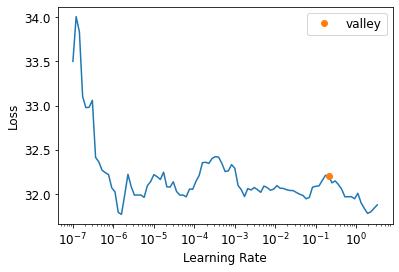

In [36]:
learn.lr_find()

In [37]:
# cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
#        MixUp(), 
#        ShowGraphCallback()]
# learn.fit_one_cycle(35, lr_max = slice(1e-6, 1e-5), cbs = cbs)

In [38]:
learn.unfreeze()

SuggestedLRs(valley=0.0012022644514217973)

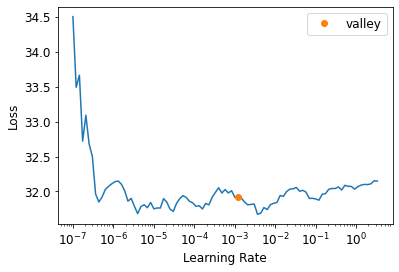

In [39]:
learn.lr_find()

In [40]:
# cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
#        MixUp(), 
#        ShowGraphCallback()]
learn.fit_one_cycle(50, lr_max = slice(1e-5, 1e-3))#, cbs = cbs)

KeyboardInterrupt: 

In [ ]:
learn.lr_find()

In [33]:
# cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
#        MixUp(), 
#        ShowGraphCallback()]
learn.fine_tune(80, base_lr=1e-4,freeze_epochs=20)#, cbs = cbs)

KeyboardInterrupt: 

<a name='metrics'></a> 
## Métricas

In [34]:
learn.metrics = accuracy_multi_atsia
learn.validate()

(#2) [0.4629759192466736,0.5322033898305084]

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_multi_confusion_matrix(figsize=(10,10))

In [ ]:
# interp.plot_top_losses(9, nrows = 3)

In [ ]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [42]:
preds,targs = learn.get_preds()

In [43]:
preds[0]

TensorBase([8.7796e-01, 3.2240e-01, 1.1414e-03, 4.5335e-04, 1.3897e-04, 2.3374e-01, 8.6689e-01, 4.5884e-03, 2.8264e-05, 1.9242e-03, 9.5517e-01, 5.0063e-02, 6.5220e-02, 5.1520e-04, 8.2604e-04, 9.9613e-01,
        6.7206e-03, 8.0178e-05, 1.3556e-04, 1.0825e-04, 9.9937e-01, 5.4774e-04, 1.9985e-05, 2.9291e-05, 1.4060e-04])

In [44]:
targs[0]

TensorMultiCategory([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [45]:
def get_preds_norm(x):
    preds_norm = np.array(np.zeros(x.shape))
    for i in range(0, len(x)):
        cat = []
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                temp = x[i][len(grados)*j : len(grados)*(j+1)]
            else:
                temp = x[i][len(grados)*j :]

            temp_new = np.zeros(len(temp))
            temp_new[temp.argmax()] = 1
            cat = np.append(cat, temp_new)
        preds_norm[i] = np.array(cat)

    preds_norm = torch.from_numpy(preds_norm)
    
    return preds_norm

In [46]:
from sklearn.metrics import multilabel_confusion_matrix
predsnorm = get_preds_norm(preds)
vis_arr = multilabel_confusion_matrix(targs, predsnorm)

In [47]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFM - " + class_label)

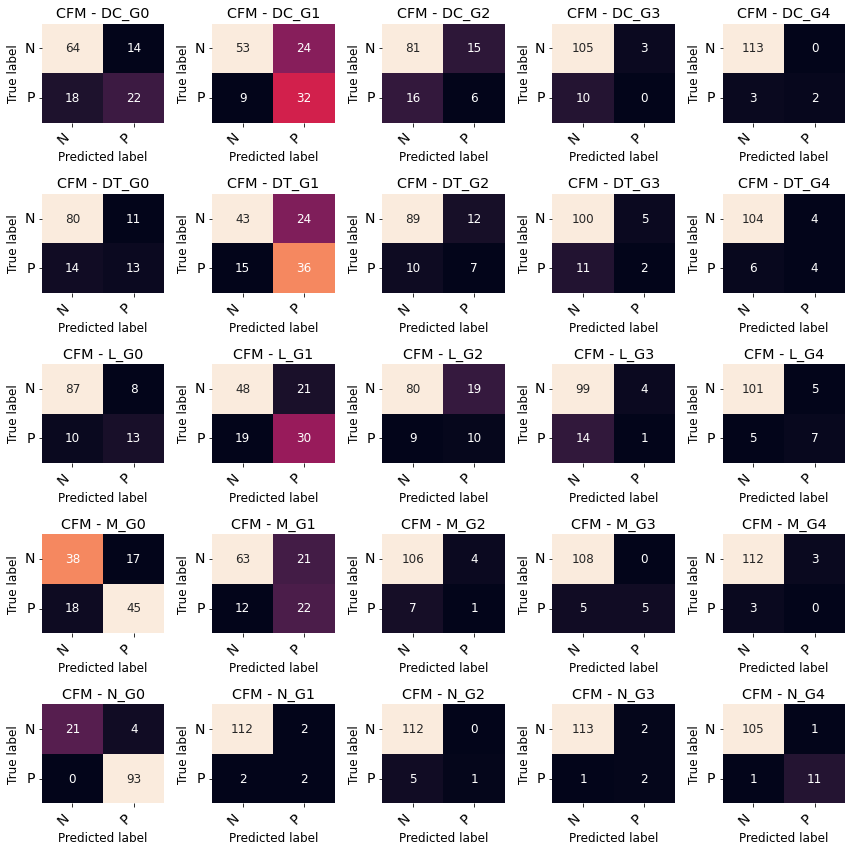

In [48]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "P"])

fig.tight_layout()
plt.show()

In [ ]:
# fnames=get_image_files(path["img"][organo])
# learn.predict(fnames[0])

In [ ]:
# fnames[0]

<a name='results'></a> 
## Resultados

In [49]:
learn.load(Path("model_test"))

In [53]:
learn.metrics = accuracy_multi_atsia
learn.validate()

IndexError: list index out of range

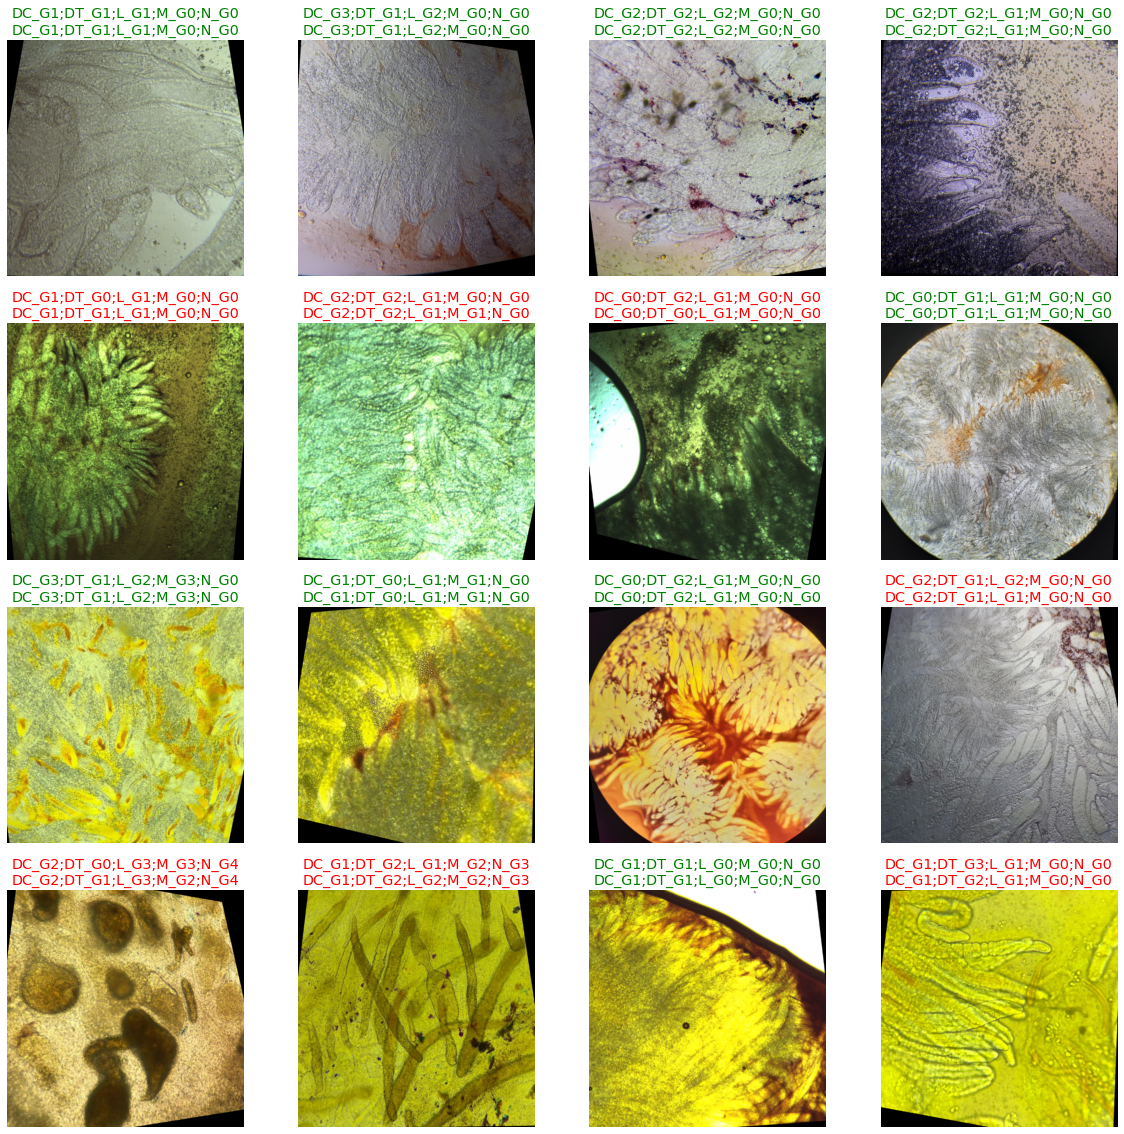

In [51]:
learn.show_results(dl = dls.train, ds_idx = 0, max_n = 16, figsize = (20,20), shuffle=False)

<a name='widget'></a> 
## Widget Test

In [54]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [55]:
img = PILImage.create(btn_upload.data[-1])

In [56]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(500,500))
out_pl

Output()

In [57]:
pred,pred_idx,probs = learn.predict(img)
pred

(#5) ['DC_G3','DT_G2','L_G1','M_G2','N_G3']

## Conclusion

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression